In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os

# scTRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
res_list = [0.2, 0.7, 2, 5]

DF_HOM = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


tms_facs


2021-08-15 22:56:13,857 - harmonypy - INFO - Iteration 1 of 20
2021-08-15 22:56:14,995 - harmonypy - INFO - Iteration 2 of 20
2021-08-15 22:56:15,990 - harmonypy - INFO - Iteration 3 of 20
2021-08-15 22:56:16,597 - harmonypy - INFO - Iteration 4 of 20
2021-08-15 22:56:17,348 - harmonypy - INFO - Iteration 5 of 20
2021-08-15 22:56:17,858 - harmonypy - INFO - Iteration 6 of 20
2021-08-15 22:56:18,319 - harmonypy - INFO - Iteration 7 of 20
2021-08-15 22:56:18,782 - harmonypy - INFO - Iteration 8 of 20
2021-08-15 22:56:19,244 - harmonypy - INFO - Iteration 9 of 20
2021-08-15 22:56:19,754 - harmonypy - INFO - Iteration 10 of 20
2021-08-15 22:56:20,266 - harmonypy - INFO - Iteration 11 of 20
2021-08-15 22:56:20,729 - harmonypy - INFO - Iteration 12 of 20
2021-08-15 22:56:21,867 - harmonypy - INFO - Iteration 13 of 20
2021-08-15 22:56:22,329 - harmonypy - INFO - Iteration 14 of 20
2021-08-15 22:56:22,839 - harmonypy - INFO - Iteration 15 of 20
2021-08-15 22:56:23,253 - harmonypy - INFO - Iter

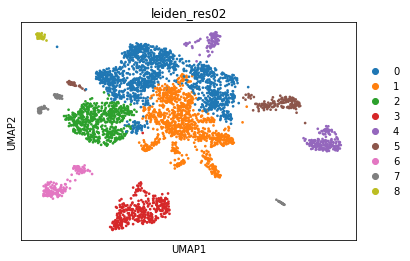

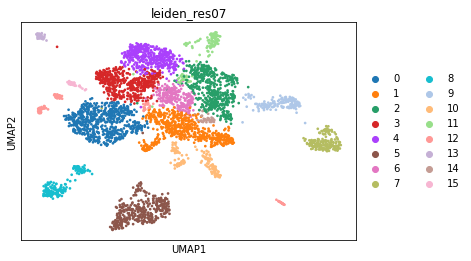

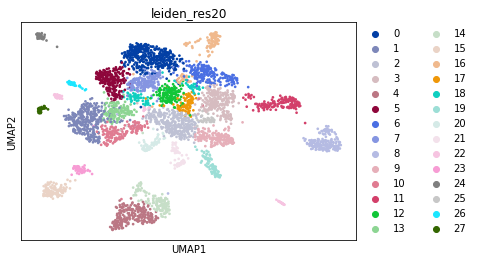

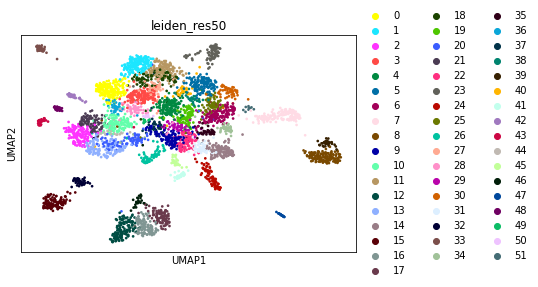

In [35]:
# # Reprocess t cell data
# for ds in ['tms_facs']:
#     print(ds)
#     ind_select = [('T cell' in x)  for x in dic_data_raw[ds].obs['tissue_celltype']]
#     adata = dic_data_raw[ds][ind_select,:].copy()
#     sc.pp.filter_cells(adata, min_genes=250)
#     sc.pp.filter_genes(adata, min_cells=50)
#     adata.obs['batch_harmony'] = adata.obs['mouse.id']
#     adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

#     sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
#                                 min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
#     sc.pp.scale(adata, max_value=10, zero_center=False)
#     sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
#     sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     for res in res_list:
#         key_added = ('leiden_res%0.1f'%res).replace('.','')
#         sc.tl.leiden(adata, resolution=res, key_added=key_added)   
#     sc.tl.umap(adata)
#     for res in res_list:
#         key_added = ('leiden_res%0.1f'%res).replace('.','')
#         sc.pl.umap(adata, color=key_added)
#     adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/tms_proc/'
#                 'tcell.%s.recluster_4res.h5ad'%ds)

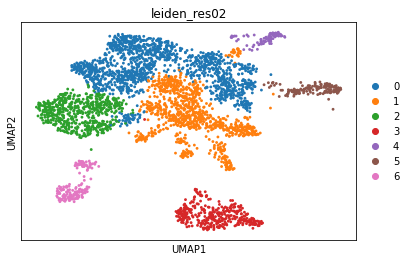

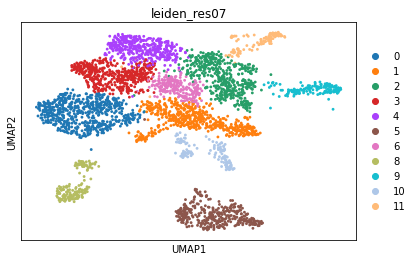

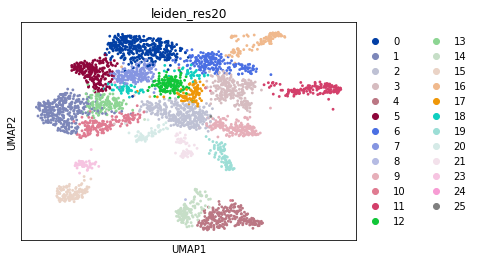

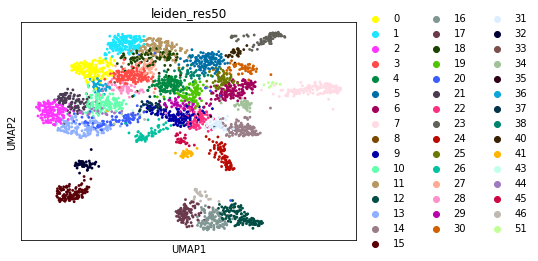

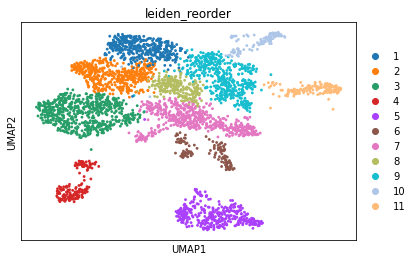

In [4]:
# # Align clusters 
# adata = dic_data_proc['tms_facs'].copy()
# temp_adata = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.tms_facs.recluster_4res.h5ad')
# temp_adata = temp_adata[adata.obs_names,:].copy()
# leiden_list = [x for x in temp_adata.obs.columns if x.startswith('leiden_res')]
# adata.obs = adata.obs.join(temp_adata.obs[leiden_list])
# for leiden in leiden_list+['leiden_reorder']:
#     sc.pl.umap(adata, color=leiden)
# adata.write(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot_cluster_4res.h5ad')

In [9]:
# Get SEGs: comparing to other TMS cells 
adata = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot_cluster_4res.h5ad')
leiden_list = [x for x in adata.obs.columns if x.startswith('leiden_res')]
adata_full = dic_data_raw['tms_facs'].copy()
adata_full.obs = adata_full.obs.join(adata.obs[leiden_list])
df_gs = pd.DataFrame(columns=['TRAIT','GENESET'])

for leiden in leiden_list:
    group_list = [x for x in adata_full.obs[leiden].cat.categories if (adata_full.obs[leiden]==x).sum()>1]
    sc.tl.rank_genes_groups(adata_full, groupby=leiden, groups=group_list, key_added=leiden)
    for cluster in group_list:
        df_gene = sc.get.rank_genes_groups_df(adata_full, group=cluster, key=leiden)
        df_gene['HUMAN'] = [DIC_MAP_M2H[x] if x in DIC_MAP_M2H else 'nonmap'  for x in df_gene['names']]
        df_gene = df_gene.loc[df_gene['HUMAN']!='nonmap'].copy()
        df_gs.loc['%s.C%s'%(leiden,cluster)] = ['%s.C%s'%(leiden,cluster), ','.join(df_gene['HUMAN'][:1000])]
df_gs.to_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_cluster_seg_4res_vsall.gs',
             sep='\t')

... storing 'tissue_celltype' as categorical


In [10]:
# Get SEGs: comparing to only T cells 
adata = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot_cluster_4res.h5ad')
leiden_list = [x for x in adata.obs.columns if x.startswith('leiden_res')]
adata_full = dic_data_raw['tms_facs'][adata.obs_names,:].copy()
adata_full.obs = adata_full.obs.join(adata.obs[leiden_list])
df_gs = pd.DataFrame(columns=['TRAIT','GENESET'])

for leiden in leiden_list:
    group_list = [x for x in adata_full.obs[leiden].cat.categories if (adata_full.obs[leiden]==x).sum()>1]
    sc.tl.rank_genes_groups(adata_full, groupby=leiden, groups=group_list, key_added=leiden)
    for cluster in group_list:
        df_gene = sc.get.rank_genes_groups_df(adata_full, group=cluster, key=leiden)
        df_gene['HUMAN'] = [DIC_MAP_M2H[x] if x in DIC_MAP_M2H else 'nonmap'  for x in df_gene['names']]
        df_gene = df_gene.loc[df_gene['HUMAN']!='nonmap'].copy()
        df_gs.loc['%s.C%s'%(leiden,cluster)] = ['%s.C%s'%(leiden,cluster), ','.join(df_gene['HUMAN'][:1000])]
df_gs.to_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_cluster_seg_4res_vstcell.gs',
             sep='\t')

... storing 'tissue_celltype' as categorical


In [12]:
df_gs=pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_cluster_seg_4res_vstcell.gs', 
                    sep='\t', index_col=0)
df_gs_ref=pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gs_file/tcell_cluster_seg_4res.081121.gs', 
                        sep='\t', index_col=0)
for gs in df_gs_ref.index:
    print(gs, len(set(df_gs.loc[gs, 'GENESET'].split(',')) & set(df_gs_ref.loc[gs, 'GENESET'].split(','))))

leiden_res02.C0 468
leiden_res02.C1 409
leiden_res02.C2 407
leiden_res02.C3 550
leiden_res02.C4 670
leiden_res02.C5 488
leiden_res02.C6 525
leiden_res07.C0 399
leiden_res07.C1 505
leiden_res07.C2 505
leiden_res07.C3 511
leiden_res07.C4 538
leiden_res07.C5 550
leiden_res07.C6 572
leiden_res07.C8 525
leiden_res07.C9 486
leiden_res07.C10 305
leiden_res07.C11 645
leiden_res20.C0 534
leiden_res20.C1 429
leiden_res20.C2 499
leiden_res20.C3 547
leiden_res20.C4 582
leiden_res20.C5 550
leiden_res20.C6 566
leiden_res20.C7 560
leiden_res20.C8 777
leiden_res20.C9 555
leiden_res20.C10 462
leiden_res20.C11 488
leiden_res20.C12 633
leiden_res20.C13 487
leiden_res20.C14 521
leiden_res20.C15 545
leiden_res20.C16 645
leiden_res20.C17 592
leiden_res20.C18 398
leiden_res20.C19 444
leiden_res20.C20 404
leiden_res20.C21 264
leiden_res20.C23 566
leiden_res50.C0 568
leiden_res50.C1 538
leiden_res50.C2 501
leiden_res50.C3 545
leiden_res50.C4 626
leiden_res50.C5 585
leiden_res50.C6 549
leiden_res50.C7 512
leide

In [8]:
df_gs

,TRAIT,GENESET
leiden_res02.C0,leiden_res02.C0,"CCR7,LEF1,SELL,SATB1,GRAMD2B,RPS6,ATP1B3,TSC22..."
leiden_res02.C1,leiden_res02.C1,"NKG7,CCL5,CTSW,GIMAP7,GIMAP4,CXCR3,CD7,ID2,GZM..."
leiden_res02.C2,leiden_res02.C2,"TNFRSF4,CTLA4,TNFRSF18,NRP1,IKZF2,CAPG,SHISA5,..."
leiden_res02.C3,leiden_res02.C3,"TMEM176B,TMEM176A,CAPG,S100A4,RAMP1,CXCR6,CKB,..."
leiden_res02.C4,leiden_res02.C4,"STMN1,HMGB2,CKS1B,TUBA1B,RAN,TUBB,TOP2A,SPC24,..."
...,...,...
leiden_res50.C41,leiden_res50.C41,"IGFBP7,CLDN5,ESAM,SPARC,IFITM2,PTPRB,APOE,IFIT..."
leiden_res50.C44,leiden_res50.C44,"ACTB,TNFRSF4,FTH1,TNFRSF18,PTPRCAP,RPS13,ARHGD..."
leiden_res50.C45,leiden_res50.C45,"C1QB,C1QC,C1QA,APOE,FCER1G,CST3,CTSB,TYROBP,AI..."
leiden_res50.C46,leiden_res50.C46,"LGALS1,TMEM176A,S100A4,CAPG,CRIP1,S100A6,TMEM1..."
